**Data:** [Dataset Link](https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset/data)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tqdm import tqdm

In [2]:
violence = os.listdir('/content/drive/MyDrive/Real_Life_Violence_Dataset/Violence')
nonviolence = os.listdir('/content/drive/MyDrive/Real_Life_Violence_Dataset/NonViolence')

In [3]:
len(violence),violence[0]

(1000, 'V_115.mp4')

In [4]:
violence_path = [os.path.join('/content/drive/MyDrive/Real_Life_Violence_Dataset/Violence',name) for name in violence]
nonviolence_path = [os.path.join('/content/drive/MyDrive/Real_Life_Violence_Dataset/NonViolence',name) for name in nonviolence]

In [5]:
violence_path[0]

'/content/drive/MyDrive/Real_Life_Violence_Dataset/Violence/V_115.mp4'

### Random Video from Dataset

In [6]:
from IPython.display import Video
def playVideo(path):
    return Video(path,embed=True)

playVideo('/content/drive/MyDrive/Real_Life_Violence_Dataset/Violence/V_100.mp4')

## Extracting Features

In [2]:
pretrained_model = InceptionV3()
pretrained_model = Model(inputs=pretrained_model.input,outputs=pretrained_model.layers[-2].output)

In [3]:
pretrained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [4]:
def feature_extractor(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (299, 299))
    frame = frame / 255.0
    img = np.expand_dims(frame, axis=0)
    feature_vector = pretrained_model.predict(img, verbose=0)
    return feature_vector

In [5]:
def frames_extraction(video_path, sequence_length=16, image_width=299, image_height=299, num_of_videos=0):
    videos_features = []

    for pos in tqdm(range(num_of_videos)):
        frames_list = []

        video_reader = cv2.VideoCapture(video_path[pos])
        video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        skip_frames_window = max(int(video_frames_count / sequence_length), 1)

        for frame_counter in range(sequence_length):
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
            success, frame = video_reader.read()

            if not success:
                break

            features = feature_extractor(frame)
            frames_list.append(features)
        videos_features.append(frames_list)
        video_reader.release()
    return np.array(videos_features)

In [ ]:
violence_features = frames_extraction(violence_path,num_of_videos=len(violence_path))
non_violence_features = frames_extraction(nonviolence_path,num_of_videos=len(nonviolence_path))

100%|██████████| 1000/1000 [43:45<00:00,  2.63s/it]


In [ ]:
np.save('/content/drive/MyDrive/violence_features.npy',violence_features)

In [ ]:
np.save('/content/drive/MyDrive/non_violence_features.npy',non_violence_features)

In [6]:
non_violence_data = np.load('non_violence_features.npy')
violence_data = np.load('violence_features.npy')

In [7]:
violence_data[0].shape

(16, 1, 2048)

In [8]:
from keras.layers import LSTM, Dense,Bidirectional,BatchNormalization,Dropout
from sklearn.model_selection import train_test_split

violence_labels = np.zeros(len(violence_data))
nonviolence_labels = np.ones(len(non_violence_data))

X = np.concatenate([violence_data, non_violence_data], axis=0)
y = np.concatenate([violence_labels, nonviolence_labels], axis=0)

In [9]:
print(len(X),X[0].shape)

2000 (16, 1, 2048)


In [10]:
y[0:20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

## Train- Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

X_train_reshaped = X_train.reshape((X_train.shape[0], 16, 2048))# reshape to (16,2048)
X_test_reshaped = X_test.reshape((X_test.shape[0], 16, 2048))# reshape to (16,2048)

## Model Building

In [12]:
inputs = Input(shape=(16, 2048))

x = Bidirectional(LSTM(200, return_sequences=True))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(100))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(200, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 2048)]        0         
                                                                 
 bidirectional (Bidirection  (None, 16, 400)           3598400   
 al)                                                             
                                                                 
 batch_normalization_94 (Ba  (None, 16, 400)           1600      
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 16, 400)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               400800    
 onal)                                                           
                                                           

## Model Compilation

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Callbacks

In [15]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [16]:
checkpoint = ModelCheckpoint(
    filepath = 'best_model.keras',
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only = False,
    mode = "auto",
    save_freq = "epoch"
)
earlystop = EarlyStopping(
    monitor='val_loss',patience=3
)

## Model Training

In [17]:
model.fit(X_train_reshaped,y_train,validation_data=(X_test_reshaped,y_test),epochs=10,batch_size=32,callbacks = [checkpoint,earlystop])

Epoch 1/10


50/50 [==============================] - 15s 170ms/step - loss: 0.2621 - accuracy: 0.8806 - val_loss: 0.4577 - val_accuracy: 0.7700
Epoch 2/10
50/50 [==============================] - 6s 125ms/step - loss: 0.1045 - accuracy: 0.9600 - val_loss: 0.4697 - val_accuracy: 0.7200
Epoch 3/10
50/50 [==============================] - 7s 132ms/step - loss: 0.0774 - accuracy: 0.9725 - val_loss: 0.2971 - val_accuracy: 0.8775
Epoch 4/10
50/50 [==============================] - 7s 134ms/step - loss: 0.0701 - accuracy: 0.9756 - val_loss: 0.2397 - val_accuracy: 0.8950
Epoch 5/10
50/50 [==============================] - 7s 134ms/step - loss: 0.0692 - accuracy: 0.9737 - val_loss: 0.0923 - val_accuracy: 0.9725
Epoch 6/10
50/50 [==============================] - 7s 132ms/step - loss: 0.0453 - accuracy: 0.9856 - val_loss: 0.0795 - val_accuracy: 0.9800
Epoch 7/10
50/50 [==============================] - 6s 127ms/step - loss: 0.0617 - accuracy: 0.9825 - val_loss: 0.1003 - val_accuracy: 0.9675
Epo

## Plots

In [18]:
hist = model.history.history

In [19]:
hist

{'loss': [0.26210230588912964,
  0.10446996986865997,
  0.07739409059286118,
  0.07006765156984329,
  0.06918307393789291,
  0.04528680816292763,
  0.06174103170633316,
  0.04032650589942932,
  0.03453042358160019],
 'accuracy': [0.8806250095367432,
  0.9599999785423279,
  0.9725000262260437,
  0.9756249785423279,
  0.9737499952316284,
  0.9856250286102295,
  0.9825000166893005,
  0.9837499856948853,
  0.9850000143051147],
 'val_loss': [0.4576558768749237,
  0.4696674644947052,
  0.29708531498908997,
  0.23970790207386017,
  0.09234466403722763,
  0.07952338457107544,
  0.10031276941299438,
  0.11472064256668091,
  0.15564316511154175],
 'val_accuracy': [0.7699999809265137,
  0.7200000286102295,
  0.8774999976158142,
  0.8949999809265137,
  0.9725000262260437,
  0.9800000190734863,
  0.9674999713897705,
  0.9524999856948853,
  0.9399999976158142]}

In [20]:
plt.style.use('seaborn-v0_8')

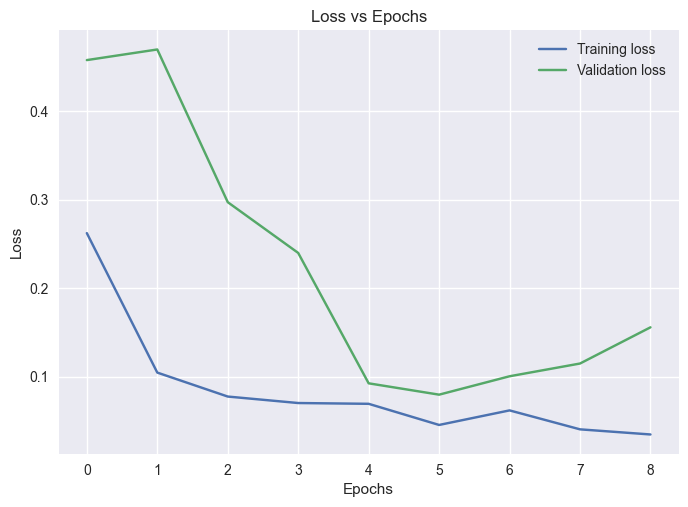

In [21]:
plt.title('Loss vs Epochs')
plt.plot(hist['loss'],label='Training loss')
plt.plot(hist['val_loss'],label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

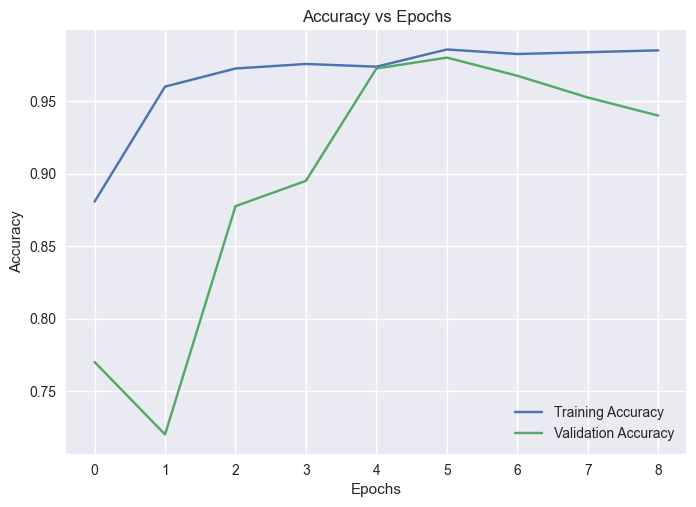

In [22]:
plt.title('Accuracy vs Epochs')
plt.plot(hist['accuracy'],label='Training Accuracy')
plt.plot(hist['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Load saved model

In [23]:
from tensorflow.keras.models import load_model

model = load_model('best_model.keras')

In [24]:
accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Accuracy:", accuracy[1])

13/13 [==============================] - 3s 25ms/step - loss: 0.0795 - accuracy: 0.9800
Test Accuracy: 0.9800000190734863


In [25]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_reshaped)
y_preds = [1 if i > 0.5 else 0 for i in y_pred]

report = classification_report(y_test, y_preds)
print("Classification Report:\n", report)

13/13 [==============================] - 2s 24ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       190
         1.0       0.97      0.99      0.98       210

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

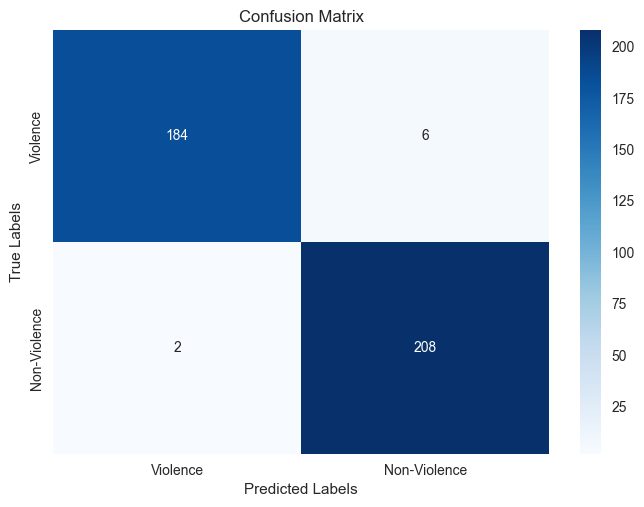

In [28]:
cm = confusion_matrix(y_test, y_preds)
class_names = ["Violence", "Non-Violence"]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()